In [57]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import logging
from torchvision import transforms
import sklearn.metrics

dtype = torch.float
# device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU

### Load Fashion MNIST dataset bundled with PyTorch

In [2]:
tf = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,)),
])
ds = torchvision.datasets.FashionMNIST('./datasets', download=True, transform=tf)
ds_test = torchvision.datasets.FashionMNIST('./datasets', train=False, transform=tf)

print("Dataset size: test=%s train=%s" % (len(ds), len(ds_test)))

Dataset size: test=60000 train=10000


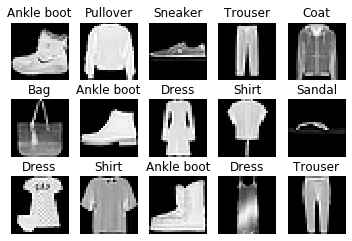

In [3]:
# Show sample images
sample_rows, sample_cols = 3, 5
for idx in range(sample_rows*sample_cols):
    sample_idx = idx*7
    plt.subplot(sample_rows, sample_cols, idx+1)
    plt.title(ds.classes[ds.targets[sample_idx]])
    plt.axis('off')
    plt.imshow(ds.data[sample_idx], cmap='gray')

### Model attempt 1: one hidden layer + ReLU + softmax + NLL loss

In [59]:
class M1:
    batch_size = 300
    hidden_dim = 500
    num_epochs = 10
    input_dim = 28*28
    output_dim = len(ds.classes)
    learning_rate = 0.1

    def __init__(self):
        self.weights_1 = torch.randn(self.hidden_dim, self.input_dim, requires_grad=True,
                                     device=device, dtype=dtype)
        self.weights_2 = torch.randn(self.output_dim, self.hidden_dim, requires_grad=True,
                                     device=device, dtype=dtype)

    def loss(self, x, y):
        x = x.to(device).reshape(len(x), self.input_dim).float() / 255.0
        y = y.to(device)
        model = F.linear(x, self.weights_1)
        model = F.relu(model)
        model = F.linear(model, self.weights_2)
        return F.cross_entropy(model, y, reduction='mean')

    def predict(self, x):
        x = x.to(device).reshape(len(x), self.input_dim).float() / 255.0
        model = F.linear(x, self.weights_1)
        model = F.relu(model)
        model = F.linear(model, self.weights_2)
        _, pred = torch.max(F.softmax(model, dim=1), dim=1)
        return pred

    def evaluate(self):
        with torch.no_grad():
            test_loss = self.loss(ds_test.data, ds_test.targets)
            acc = (self.predict(ds_test.data) == ds_test.targets.to(device)).float().mean()
            print("test loss %.2f acc %0.2f" % (test_loss.item(), acc.item()))

    def train(self):
        optimizer = torch.optim.Adam([self.weights_1, self.weights_2], lr=self.learning_rate)
        loader = torch.utils.data.DataLoader(ds, batch_size=self.batch_size, shuffle=True)
        for epoch_idx in range(self.num_epochs):
            for batch_idx, (batch_x, batch_y) in enumerate(loader):
                optimizer.zero_grad()
                loss = self.loss(batch_x, batch_y)
                if batch_idx*self.batch_size % 30000 == 0:
                    print("Batch % 4d, batch train loss %.2f" % (batch_idx, loss.item()))
                loss.backward()
                optimizer.step()
            print("=== Epoch %d:" % epoch_idx, end=" ")
            self.evaluate()

In [61]:
m1 = M1()
m1.train()

Batch    0, batch train loss 2.52
Batch  100, batch train loss 0.50
=== Epoch 0: test loss 59.84 acc 0.84
Batch    0, batch train loss 0.44
Batch  100, batch train loss 0.34
=== Epoch 1: test loss 54.60 acc 0.86
Batch    0, batch train loss 0.36
Batch  100, batch train loss 0.34
=== Epoch 2: test loss 54.70 acc 0.86
Batch    0, batch train loss 0.38
Batch  100, batch train loss 0.36
=== Epoch 3: test loss 52.82 acc 0.87
Batch    0, batch train loss 0.27
Batch  100, batch train loss 0.29
=== Epoch 4: test loss 54.47 acc 0.87
Batch    0, batch train loss 0.23
Batch  100, batch train loss 0.28
=== Epoch 5: test loss 51.93 acc 0.87
Batch    0, batch train loss 0.30
Batch  100, batch train loss 0.31
=== Epoch 6: test loss 55.78 acc 0.87
Batch    0, batch train loss 0.25
Batch  100, batch train loss 0.25
=== Epoch 7: test loss 58.66 acc 0.88
Batch    0, batch train loss 0.21
Batch  100, batch train loss 0.18
=== Epoch 8: test loss 56.45 acc 0.88
Batch    0, batch train loss 0.26
Batch  100, 

Predicted class: Trouser


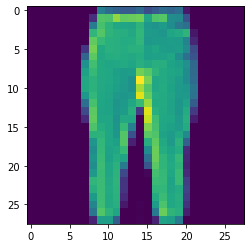

In [64]:
# Manually check some predictions
ti = 2259
plt.imshow(ds_test.data[ti])
print('Predicted class: %s' % ds_test.classes[m1.predict(ds_test.data[ti:ti+1])])

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

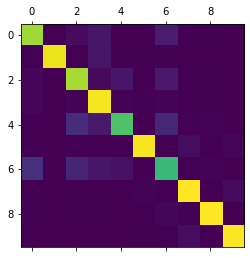

In [66]:
# Show confusion matrix; seems like "shirt" is most confused with "T-shirt/top", "Coat", and "Pullover"
cm = sklearn.metrics.confusion_matrix(ds_test.targets, m1.predict(ds_test.data).cpu())
plt.matshow(cm)
ds_test.classes

tensor(0.0607, device='cuda:0')

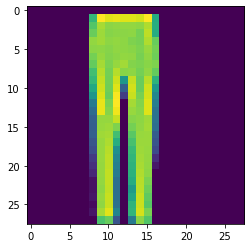

In [8]:
# This isn't a very good model; shift the image a bit, and accuracy drops to 62%
h_shift = 2
shifted = torch.cat((ds_test.data[:, :, h_shift:], torch.zeros(len(ds_test.data), 28, h_shift, dtype=torch.uint8)), dim=2)
plt.imshow(shifted[2338])
(m1.predict(shifted) == ds_test.targets.to(device)).float().mean()

### Model attempt 2: CNN with batch normalization

In [167]:
class M2(nn.Module):
    def __init__(self, num_classes):
        super(M2, self).__init__()
        self.num_classes = num_classes
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5, padding=2),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(20, 20, kernel_size=5, padding=2),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
        )
        self.linear = nn.Linear(500, self.num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.linear(out)
        return out

In [212]:
def train(net, learning_rate=0.003, batch_size=500, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    loader = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)
    for epoch_idx in range(num_epochs):
        for batch_idx, (batch_x, batch_y) in enumerate(loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            criterion(net(batch_x), batch_y).backward()
            optimizer.step()
        evaluate(net, epoch_idx, show_cm=(epoch_idx == num_epochs-1))

def evaluate(net, epoch_idx, show_cm=False, transform_input_fn=None, show_example_pred=None):
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        loader = torch.utils.data.DataLoader(ds_test, batch_size=len(ds_test.data), shuffle=True)
        _, (batch_x, batch_y) = next(enumerate(loader))
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        if transform_input_fn is not None:
            batch_x = transform_input_fn(batch_x)
        test_pred = net(batch_x)
        test_loss = criterion(test_pred, batch_y)
        _, pred_targets = torch.max(F.softmax(test_pred, dim=1), dim=1)
        test_acc = (pred_targets == batch_y).float().mean()
        print("Epoch %d: loss %.2f acc %0.2f" % (epoch_idx+1, test_loss.item(), test_acc.item()))
        # Confusion matrix
        if show_cm:
            cm = sklearn.metrics.confusion_matrix(batch_y.cpu(), pred_targets.cpu())
            plt.matshow(cm)
        if show_example_pred is not None:
            plt.imshow(batch_x[show_example_pred].cpu().reshape(28, 28))
            print('Predicted class: %s' % ds_test.classes[pred_targets[show_example_pred]])
            print('Ground truth: %s' % ds_test.classes[batch_y[show_example_pred]])

Epoch 1: loss 0.41 acc 0.86
Epoch 2: loss 0.35 acc 0.87
Epoch 3: loss 0.32 acc 0.88
Epoch 4: loss 0.30 acc 0.89
Epoch 5: loss 0.31 acc 0.89
Epoch 6: loss 0.28 acc 0.90
Epoch 7: loss 0.30 acc 0.89
Epoch 8: loss 0.28 acc 0.90
Epoch 9: loss 0.28 acc 0.90
Epoch 10: loss 0.29 acc 0.90
Epoch 11: loss 0.27 acc 0.90
Epoch 12: loss 0.28 acc 0.90
Epoch 13: loss 0.27 acc 0.90
Epoch 14: loss 0.29 acc 0.90
Epoch 15: loss 0.29 acc 0.90
Epoch 16: loss 0.28 acc 0.91
Epoch 17: loss 0.26 acc 0.91
Epoch 18: loss 0.27 acc 0.90
Epoch 19: loss 0.27 acc 0.91
Epoch 20: loss 0.29 acc 0.90


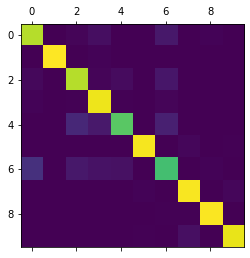

In [169]:
m2 = M2(len(ds.classes)).to(device)
train(m2, num_epochs=20)

Accuracy after shifting image by 3 pixels
M1: acc 0.45
M2: Epoch 0: loss 0.64 acc 0.78


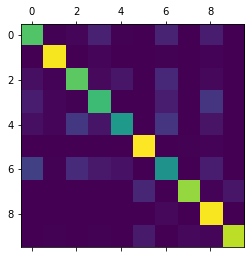

In [172]:
# M2 is more resilient to image translation than M1
h_shift = 3
shifted = torch.cat((ds_test.data[:, :, h_shift:], torch.zeros(len(ds_test.data), 28, h_shift, dtype=torch.uint8)), dim=2)
print("Accuracy after shifting image by %d pixels" % h_shift)
print("M1: acc %.2f" % (m1.predict(shifted) == ds_test.targets.to(device)).float().mean())

transform_input_fn = lambda t: torch.cat(
    (t[:, :, :, h_shift:],
     torch.zeros(t.size(0), 1, 28, h_shift, device=device)),
    dim=3)
print("M2:", end=" ")
evaluate(m2, -1, transform_input_fn=transform_input_fn, show_cm=True)

Epoch 0: loss 0.29 acc 0.90
Predicted class: Ankle boot
Ground truth: Ankle boot


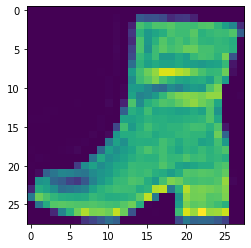

In [251]:
evaluate(m2, -1, show_example_pred=137)